In [1]:
import os
import torch
import pandas as pd

from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn.functional as F
import pickle as pkl
import matplotlib.pyplot as plt
import time

In [2]:
# Read data, convert to NumPy arrays
data = pd.read_csv("LIDAR.csv", header=None)
X = data.iloc[:, 0:16].values
y = data.iloc[:, 16].values

# convert into PyTorch tensors
trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

#----------------------------------------

print(trainingSetX.shape)
print(trainingSetY.shape)


torch.Size([5022, 16])
torch.Size([5022, 1])


In [3]:
#----------------------------------------

device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
)

#----------------------------------------

print(f"Using {device} device")

#----------------------------------------

Using cpu device


In [4]:

nds = 12

class NeuralNetwork(nn.Module):
    
    def __init__(self, inputs, outputs):
        
        super().__init__()
        
        # Simple linear connections
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 36),
            nn.ReLU(),
            nn.Linear(36, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.SiLU(),
            nn.Linear(12, 1),
            # nn.ReLU()
        )
            
    def forward(self, x):
        
        return self.linear_relu_stack(x)


#----------------------------------------

In [5]:
#----------------------------------------

epochs = 250

learningRate = 0.00008

#----------------------------------------

# Simplest possible network: 9 inputs and 1 output (binary: 0 when < 0.5 and 1 when > 0.5)
model = NeuralNetwork(16, 1)

print(model)

#----------------------------------------

losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
# lossFunction = nn.BCELoss()
lossFunction = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.SGD(model.parameters(), lr=learningRate)
# gradientDescent = torch.optim.RMSprop(model.parameters(), lr=learningRate)

#----------------------------------------

added = False

for i in range(epochs):
    
    added = False
    
    for x, y in zip(trainingSetX, trainingSetY):
    
        # Reset the gradient delta's (dw, db)
        gradientDescent.zero_grad()

        # Forward step
        yhat = model(x)

        # Compute loss
        loss = lossFunction(yhat, y)
        
        if not added:
            
            added = True
        
            # Keep track of loss
            losses.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent.step()

#----------------------------------------

# # evaluate accuracy after training
# model.eval()
# y_pred = model(trainingSetX)
# acc = (y_pred.round() == trainingSetY).float().mean()
# acc = float(acc)
# print("Model accuracy: %.2f%%" % (acc*100))

#----------------------------------------

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=16, out_features=36, bias=True)
    (1): ReLU()
    (2): Linear(in_features=36, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=12, bias=True)
    (5): SiLU()
    (6): Linear(in_features=12, out_features=1, bias=True)
  )
)


In [6]:
filehandler = open('SDCar_lidartrial.pth', 'wb')
torch.save(model.linear_relu_stack, filehandler)

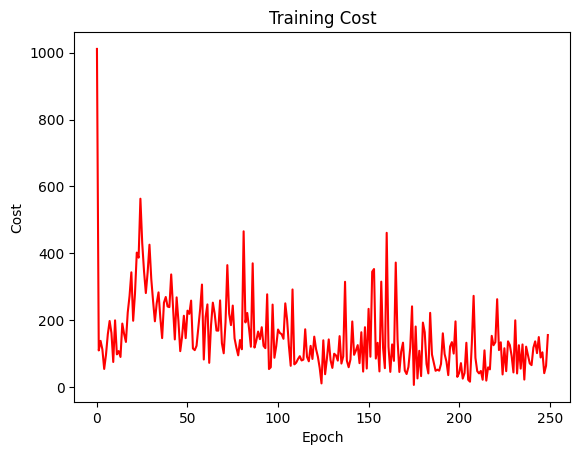

In [7]:
#----------------------------------------

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(epochs)], losses, 'red')
plt.show()

#----------------------------------------